# About this Notebook

The goal of this notebook is to build a classifier to find toxic comments. The data has been taken from a series of Kaggle competitions to classify Wikipedia comments as toxic/nontoxic. The data has been sourced from Google and Jigsaw. 

The notebook will start with simple bag-of-words and tf-idf features and use simple models like logistic regression and Naive Bayes to perform classification with these features. Though the full dataset includes non-English comments, I will restrict myself to English-only comment for this iteration. 

We will then move on to deep learning approaches, using a combination of pretrained word embeddings and simple deep learning models like RNNs and 1D convolutions to do more benchmarking. 

Next, we will explore deep learning models that have 'memory' using LSTMs (Long Short Term Memory) and GRUs (Gated Recurrent Units). 

Finally, we will approach state of the art performance using pretrained models like BERT and xlnet.

For metrics, I will focus more on recall than precision as I believe finding all toxic comments is more important that mislabelling some nontoxic comments. In addition to recall, I will look at the confusion matrix and precision-recall curves. 

Credits:
https://www.kaggle.com/tanulsingh077/deep-learning-for-nlp-zero-to-transformers-bert

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

## Load data

In [2]:
train = pd.read_csv('jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv')
#The following is a non-English dataset and won't be used presently
validation = pd.read_csv('jigsaw-multilingual-toxic-comment-classification/validation.csv')
#The following is a non-English dataset and won't be used presently
test = pd.read_csv('jigsaw-multilingual-toxic-comment-classification/test.csv')

## EDA

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223549 entries, 0 to 223548
Data columns (total 8 columns):
id               223549 non-null object
comment_text     223549 non-null object
toxic            223549 non-null int64
severe_toxic     223549 non-null int64
obscene          223549 non-null int64
threat           223549 non-null int64
insult           223549 non-null int64
identity_hate    223549 non-null int64
dtypes: int64(6), object(2)
memory usage: 13.6+ MB


We will drop the other columns and approach this problem as a Binary Classification Problem and also we will have our exercise done on a smaller subsection of the dataset(only 12000 data points) to make it easier to train the models

In [5]:
train.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)

In [6]:
train = train.loc[:10000,:]
train.comment_text[train.toxic==1][1:2].values

array(['Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'],
      dtype=object)

In [7]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.comment_text.values, train.toxic.values, 
                                                  stratify=train.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)


count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(xtrain)
count_valid = count_vectorizer.transform(xvalid)


## Sanity Checks

In [8]:
sum(sum(count_train.A[:5]))
count_vectorizer.vocabulary_['hello']


13360

In [9]:
sum(count_train.A,0)


array([29, 75,  5, ...,  1,  1,  1])

## Train Naive Bayes Model

In [10]:
nb_classifier = MultinomialNB()

nb_classifier.fit(count_train, ytrain)
pred = nb_classifier.predict(count_valid)
pred_proba = nb_classifier.predict_proba(count_valid)
accuracy = metrics.accuracy_score(yvalid, pred)
print(metrics.confusion_matrix(yvalid, pred, labels=[0,1]))
print("Accuracy Score: {0:0.2f}".format(accuracy))

[[1798    9]
 [ 103   91]]
Accuracy Score: 0.94


Average precision-recall score: 0.48


0.4783299329716585

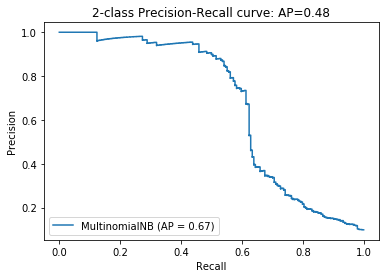

In [14]:
average_precision = metrics.average_precision_score(yvalid, pred)
#average_recall = metrics.recall_score(yvalid, pred)
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))


disp = metrics.plot_precision_recall_curve(nb_classifier, count_valid, yvalid)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
average_precision

## Use Tfidf for the features

In [15]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
count_train_idf = tfidf_vectorizer.fit_transform(xtrain)
count_valid_idf = tfidf_vectorizer.transform(xvalid)

In [16]:
max(count_train_idf.A[0])

0.5753045144327993

In [ ]:
metrics.confusion_matrix(yvalid, pred, labels=[0,1])

[[1807    0]
 [ 181   13]]
Accuracy Score: 0.91


Text(0.5,1,'2-class Precision-Recall curve: AP=0.16')

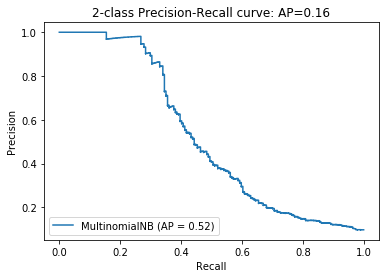

In [17]:
nb_classifier.fit(count_train_idf, ytrain)
pred = nb_classifier.predict(count_valid_idf)
pred_proba = nb_classifier.predict_proba(count_valid_idf)
accuracy = metrics.accuracy_score(yvalid, pred)
print(metrics.confusion_matrix(yvalid, pred, labels=[0,1]))
print("Accuracy Score: {0:0.2f}".format(accuracy))

average_precision = metrics.average_precision_score(yvalid, pred)

disp = metrics.plot_precision_recall_curve(nb_classifier, count_valid, yvalid)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))